# HEIC 이미지 변환 워크플로우

이 노트북은 HEIC 이미지를 지정한 해상도와 확장자로 일괄 변환하는 예제입니다.
- 필요한 파이썬 모듈: `Pillow`, `pillow-heif`, `IPython`
- 노트북 실행 환경에 따라 모듈 설치가 필요할 수 있습니다.

In [2]:
# 이미지 처리를 위한 모듈을 불러오고 HEIC 지원을 등록합니다
from pathlib import Path
from typing import List, Tuple

from PIL import Image
from pillow_heif import register_heif_opener
from IPython.display import display

# HEIC 포맷을 PIL에서 열 수 있도록 등록
register_heif_opener()

# Pillow 버전에 따라 사용할 리샘플링 상수를 고릅니다
if hasattr(Image, "Resampling"):
    RESAMPLE = Image.Resampling.LANCZOS
else:
    RESAMPLE = Image.LANCZOS

In [3]:
# HEIC 이미지를 원하는 해상도와 확장자로 변환하는 함수입니다
def convert_heic_images(
    input_dir: Path,
    output_dir: Path,
    size: Tuple[int, int],
    extension: str,
    quality: int = 85,
    recursive: bool = False,
) -> List[Path]:
    """지정한 폴더의 HEIC 이미지를 변환한 후 결과 파일 경로 목록을 반환합니다."""
    # 변환할 해상도가 올바른지 검사합니다
    if size[0] <= 0 or size[1] <= 0:
        raise ValueError("해상도는 0보다 큰 양수여야 합니다.")

    # 확장자 문자열을 정규화하고 지원 여부를 확인합니다
    normalized_ext = extension.lower().lstrip(".")
    allowed_exts = {"jpg", "jpeg", "png", "webp", "bmp", "tiff"}
    if normalized_ext not in allowed_exts:
        raise ValueError(f"지원하지 않는 확장자입니다: {normalized_ext}")

    # JPEG 품질 범위를 확인합니다
    if normalized_ext in {"jpg", "jpeg"} and not (1 <= quality <= 95):
        raise ValueError("JPEG 품질은 1에서 95 사이여야 합니다.")

    # 출력 폴더를 준비합니다
    output_dir.mkdir(parents=True, exist_ok=True)

    # 변환된 파일 경로를 저장할 리스트입니다
    converted_paths: List[Path] = []

    # 처리할 HEIC 파일 목록을 준비합니다 (재귀 여부 선택 가능)
    pattern = "**/*.heic" if recursive else "*.heic"
    heic_files = sorted(input_dir.glob(pattern)) + sorted(input_dir.glob(pattern.upper()))
    if not heic_files:
        return []

    # 입력 폴더에서 HEIC 파일을 순회하며 처리합니다
    for heic_path in heic_files:
        with Image.open(heic_path) as image:
            # PIL의 모드에 따라 RGB 변환이 필요한 경우 처리합니다
            base_image = image.convert("RGBA") if image.mode in {"P", "CMYK"} else image
            if normalized_ext in {"jpg", "jpeg"}:
                working_image = base_image.convert("RGB")
            else:
                working_image = base_image

            # 해상도를 조정합니다
            resized_image = working_image.resize(size, RESAMPLE)

            # 저장 파일 경로를 생성합니다
            target_path = output_dir / f"{heic_path.stem}.{normalized_ext}"

            # 확장자에 따른 저장 옵션을 구성합니다
            save_params = {}
            if normalized_ext in {"jpg", "jpeg"}:
                save_params["quality"] = quality
                save_params["optimize"] = True
            elif normalized_ext == "png":
                save_params["optimize"] = True

            # 결과 이미지를 저장하고 경로를 기록합니다
            resized_image.save(target_path, **save_params)
            converted_paths.append(target_path)

    return converted_paths

HEIC 이미지가 있는 폴더 경로를 입력하세요 (기본값: 현재 폴더):  
변환된 이미지를 저장할 폴더 경로를 입력하세요 (기본값: ./converted):  
변환할 너비(px)를 입력하세요:  960
변환할 높이(px)를 입력하세요:  544
저장할 확장자를 입력하세요 (예: jpg, png):  jpg
JPEG 품질(1-95, 기본값 85)을 입력하세요 (다른 확장자는 무시):  50
하위 폴더까지 탐색할까요? (y/N):  N


총 34개의 파일을 변환했습니다.
미리보기: converted/IMG_6164.jpg


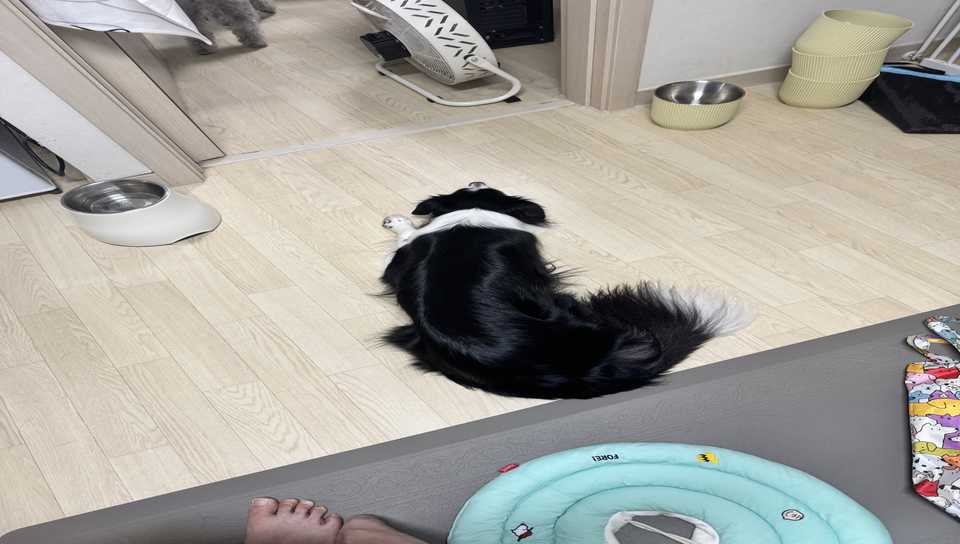

미리보기: converted/IMG_6165.jpg


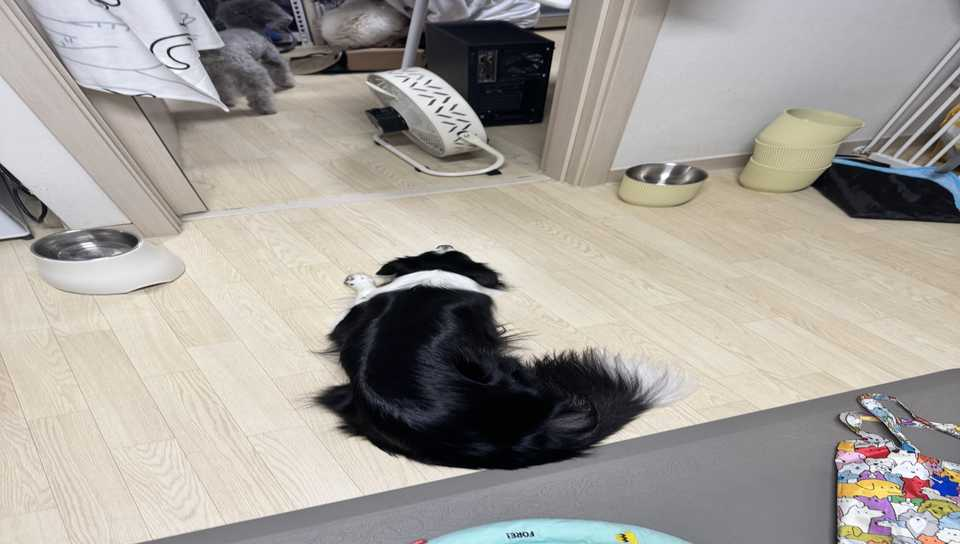

미리보기: converted/IMG_6166.jpg


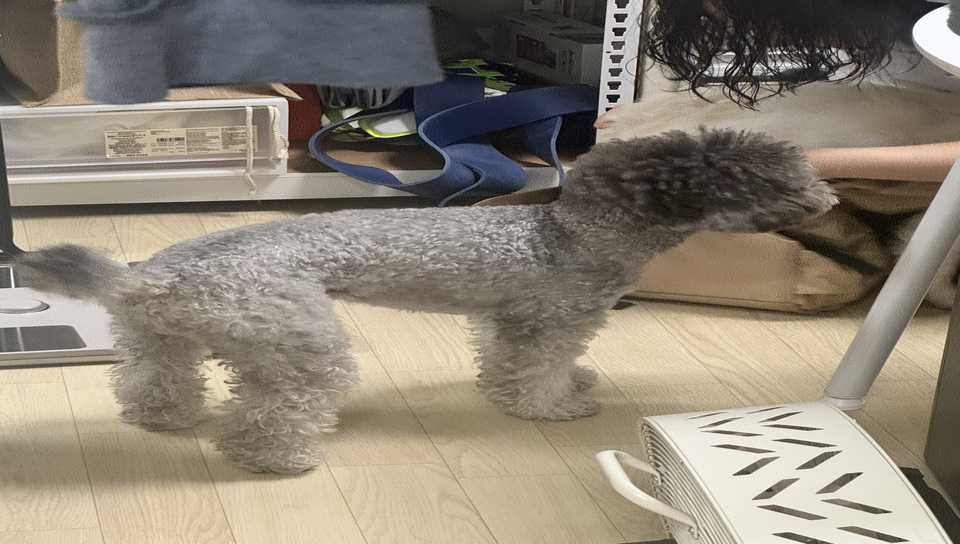

In [4]:
# 사용자 입력을 받아 변환을 실행하는 헬퍼 함수입니다
def run_interactive_workflow():
    # 사용자에게 기본 경로와 옵션을 입력받습니다
    input_dir_text = input("HEIC 이미지가 있는 폴더 경로를 입력하세요 (기본값: 현재 폴더): ").strip()
    output_dir_text = input("변환된 이미지를 저장할 폴더 경로를 입력하세요 (기본값: ./converted): ").strip()
    width_text = input("변환할 너비(px)를 입력하세요: ").strip()
    height_text = input("변환할 높이(px)를 입력하세요: ").strip()
    ext_text = input("저장할 확장자를 입력하세요 (예: jpg, png): ").strip()
    quality_text = input("JPEG 품질(1-95, 기본값 85)을 입력하세요 (다른 확장자는 무시): ").strip()
    recursive_text = input("하위 폴더까지 탐색할까요? (y/N): ").strip().lower()

    # 경로와 숫자 값 변환을 수행합니다
    input_dir = Path(input_dir_text) if input_dir_text else Path(".")
    output_dir = Path(output_dir_text) if output_dir_text else Path("./converted")
    width = int(width_text)
    height = int(height_text)
    quality = int(quality_text) if quality_text else 85
    recursive = recursive_text == "y"

    # 변환을 실행하고 결과를 출력합니다
    converted = convert_heic_images(
        input_dir,
        output_dir,
        (width, height),
        ext_text,
        quality=quality,
        recursive=recursive,
    )
    if not converted:
        print("변환할 HEIC 파일을 찾지 못했습니다.")
        return

    print(f"총 {len(converted)}개의 파일을 변환했습니다.")
    for preview_path in converted[:3]:
        print(f"미리보기: {preview_path}")
        with Image.open(preview_path) as preview:
            display(preview.copy())


# 인터랙티브 함수 실행을 위한 간단한 감싸기 코드입니다
try:
    run_interactive_workflow()
except Exception as exc:
    print(f"오류가 발생했습니다: {exc}")